# Taxi orders prediction

Sweet Lift, a taxi company, collected past data on taxi orders at an airport. To get the optimum number of drivers on standby during the rush hours, Sweet Lift needs an ML model capable of predicting the number of orders in the next hour.

Sweet Lift requests that our model's RMSE not be higher than 48.

# Preparation

## Loading libraries

In [1]:
import numpy as np
## Monkey patching: changing numpy function to prevent errors with skopt
## as downgrading to numpy < 1.20.0 is not possible with Python 3.1+
np.int = int

# For data manipulation
import pandas as pd

# For time series analyses
from statsmodels.tsa.seasonal import seasonal_decompose

# sklearn
## Tools
from sklearn.model_selection import train_test_split

## Metrics
from sklearn.metrics import mean_squared_error, make_scorer

## Models
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# Gradient-boosting models
## LightGBM
from lightgbm import LGBMRegressor
## CatBoost
from catboost import CatBoostRegressor

# Prophet forecasting model & visualization
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly

# skopt for hyperparameter tuning
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

# For data visualization
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker

# To suppress warnings generated by skopt
import warnings

# Setting random_state for the whole project
random_state = 12345

print('Libraries loaded successfully.')

Libraries loaded successfully.


## Loading data

In [2]:
# `index_col=[0]` & `parse_dates=[0]` to use the first column as a datetime index
# If run locally
try:
    df = pd.read_csv('dataset/taxi.csv', index_col=[0], parse_dates=[0])

# If run on the platform    
except:
    df = pd.read_csv('\dataset\taxi.csv', index_col=[0], parse_dates=[0])

## Data inspection

In [3]:
# Checking overall information
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [4]:
# Checking for temporal order
df.index.is_monotonic_increasing

True

In [5]:
# Showing the first and last few rows
df

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


In [6]:
# Showing statistical description of the target
df.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


Findings:
- The dataset contains 26,496 entries with no missing values.
- Each entry is indexed with a timestamp, ranging from 1 March 2018 at 00:00 to 31 August 2018 at 23:50, increasing by 10-minute increments.
- The timestamps are in order, as indicated by the return value of `True` when calling the `is_monotonic_increasing` method.
- The statistical description of the target `num_orders` showed no presence of impossible values.

# EDA

## Hourly data

We'll resample to data by hour and try to see their trend and seasonality using the `tsa.seasonal.seasonal_decompose` function. A window of 72 hours should be enough to show useful information.

In [7]:
# Resampling the data by the hour and totaling `num_orders` within the timeframe
df_hourly = df.resample('1H').sum()
df_hourly

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


Text(0.5, 1.0, 'Residuals')

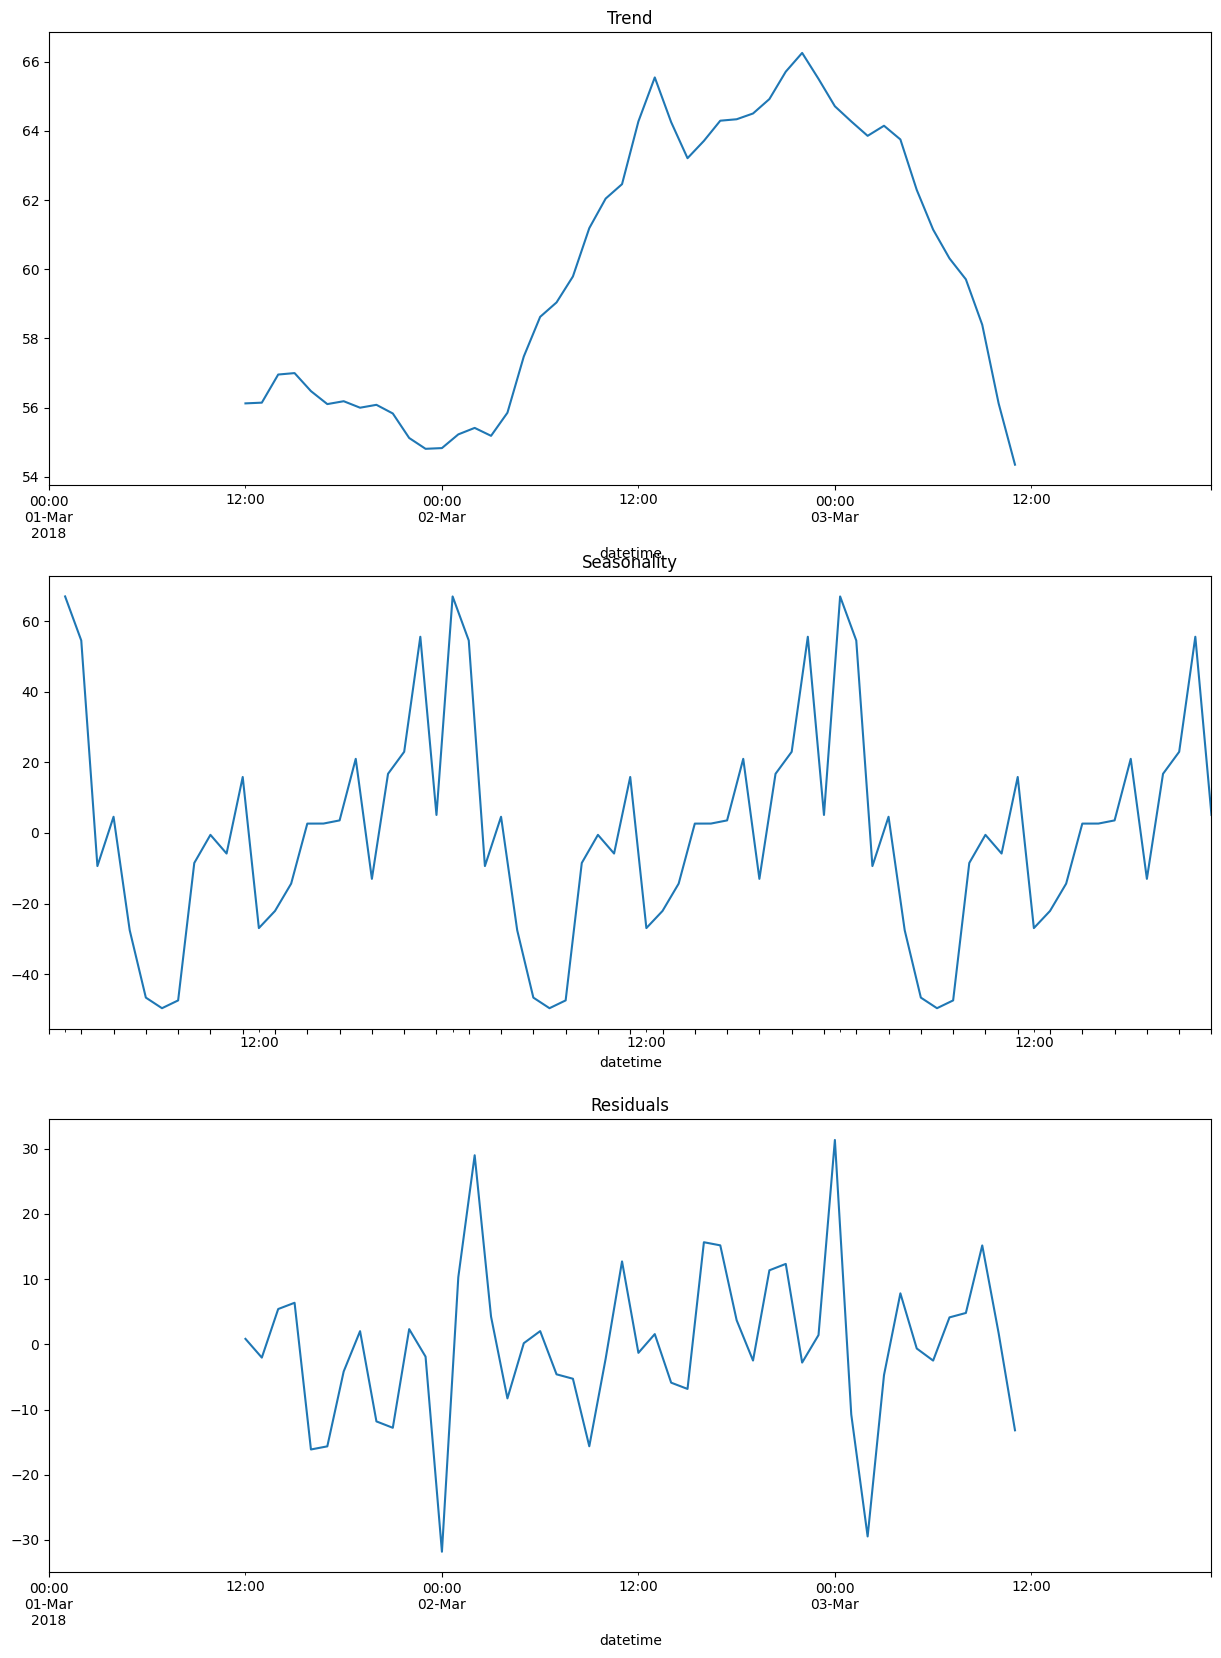

In [8]:
# Decomposing 7 days (24 hours/day * 3 days = 72 hours) of hourly data
decomposed = seasonal_decompose(df_hourly.iloc[0:72])

plt.figure(figsize=(15, 20))

# Creating subplots for the decomposed time series
# Getting axes and fitting them in the figure
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
ax=plt.gca()
plt.title('Trend')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
ax=plt.gca()
## Setting tick interval to make reading the plot easier
ax.xaxis.set_major_locator(plticker.MultipleLocator(base=1.0))
ax.set_xticks(ax.get_xticks()[::2])
plt.title('Seasonality')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
ax=plt.gca()
plt.title('Residuals')

In [9]:
# Showing the seasonal period slice
df_hourly[5:30]

,num_orders
datetime,
2018-03-01 05:00:00,6
2018-03-01 06:00:00,12
2018-03-01 07:00:00,15
2018-03-01 08:00:00,34
2018-03-01 09:00:00,69
2018-03-01 10:00:00,64
2018-03-01 11:00:00,96
2018-03-01 12:00:00,30
2018-03-01 13:00:00,32


Findings:
- Trends vary between the first 72 hours of data.
- There were around 3 cycles of seasonality in the first 72 hours of data, matching the number of days in the timeframe (3 days). Thus, it can be said that the seasonal cycle repeats daily.
- Based on the seasonality plot, each day tends to have the lowest number of orders at 06:00 AM and the highest at 00:00.

## Daily data

In [10]:
# Resampling the data by the hour and totaling `num_orders` within the timeframe
df_daily = df.resample('1D').sum()
df_daily['dayofweek'] = df_daily.index.dayofweek
df_daily

,num_orders,dayofweek
datetime,,
2018-03-01,1364,3
2018-03-02,1506,4
2018-03-03,1290,5
2018-03-04,1141,6
2018-03-05,1259,0
...,...,...
2018-08-27,3936,0
2018-08-28,3357,1
2018-08-29,3762,2


Text(0.5, 1.0, 'Residuals')

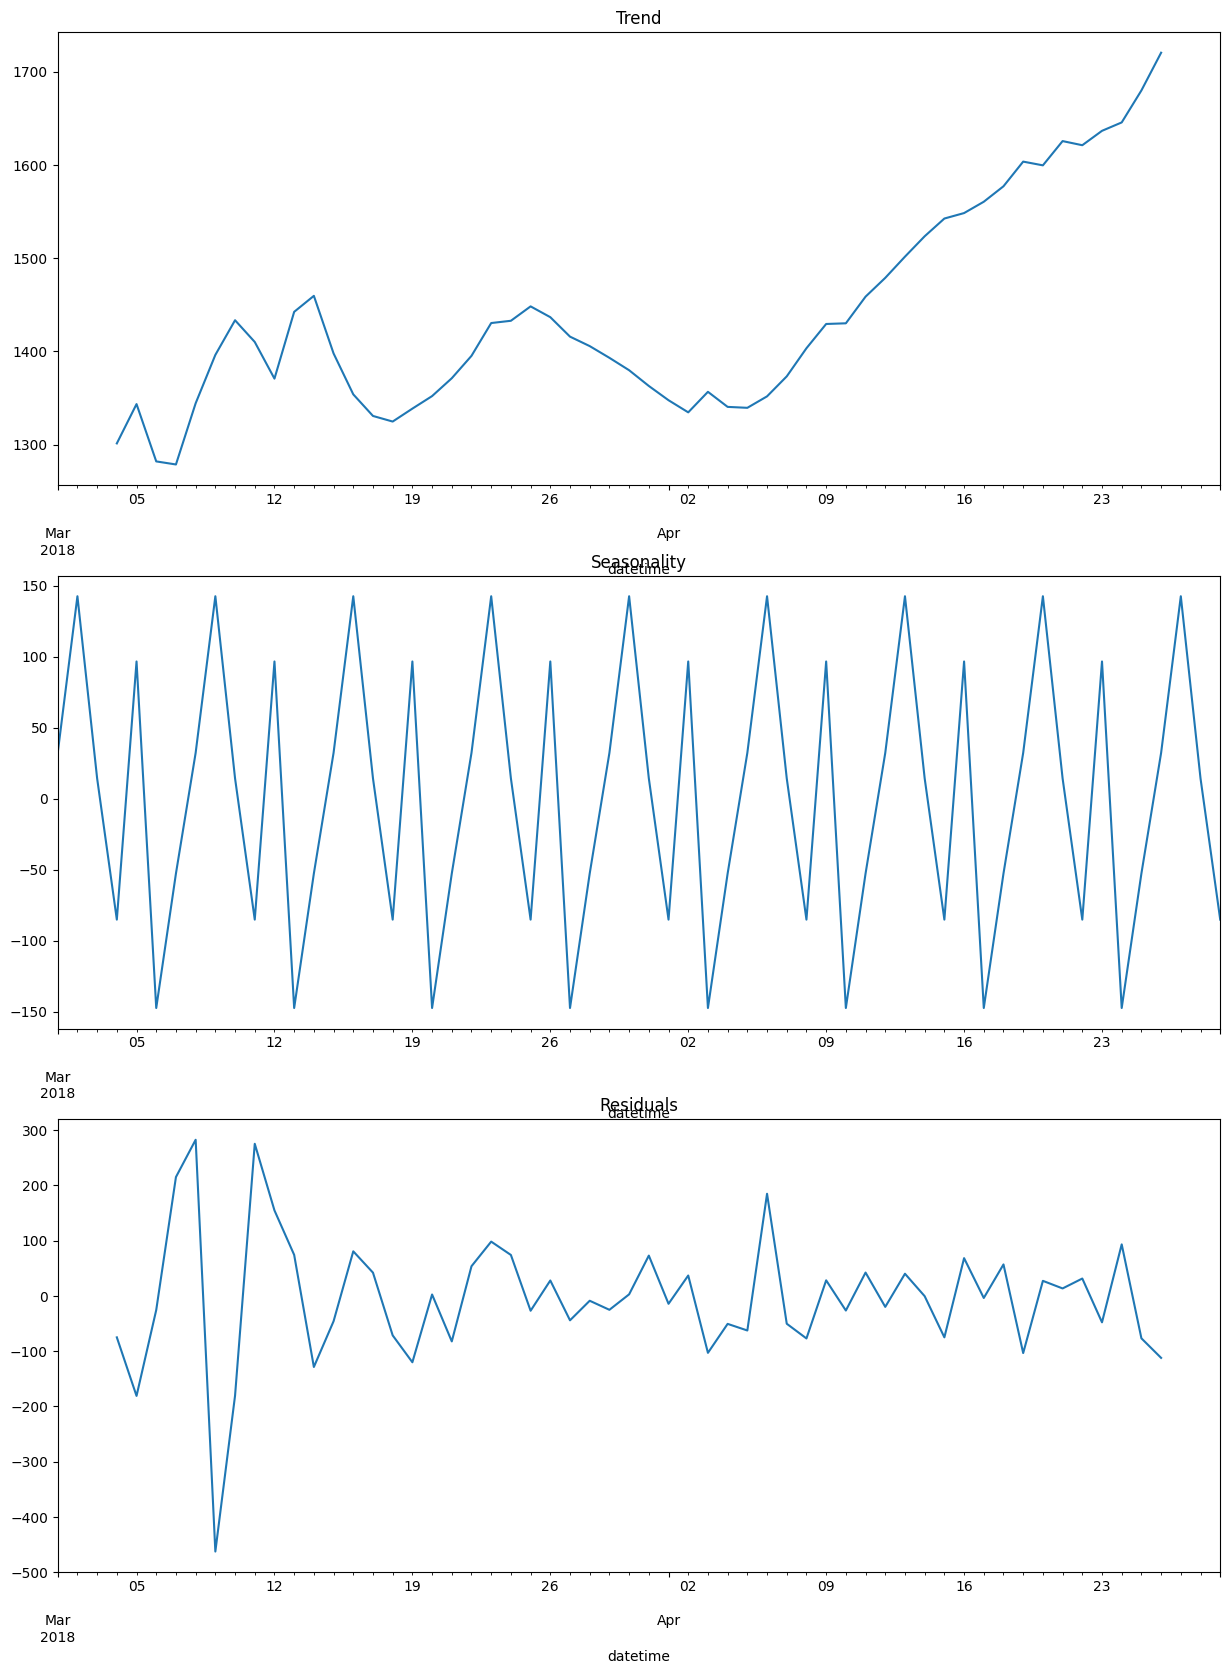

In [11]:
# Decomposing 60 days of daily data
decomposed = seasonal_decompose(df_daily['num_orders'].iloc[0:60])

plt.figure(figsize=(15, 20))

# Creating subplots for the decomposed time series
# Getting axes and fitting them in the figure
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
ax=plt.gca()
plt.title('Trend')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
ax=plt.gca()
ax.set_xticks(ax.get_xticks()[::2])
plt.title('Seasonality')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
ax=plt.gca()
plt.title('Residuals')

In [12]:
# Slicing one cycle of seasonality
df_daily.iloc[5:22]

,num_orders,dayofweek
datetime,,
2018-03-06,1109,1
2018-03-07,1441,2
2018-03-08,1659,3
2018-03-09,1076,4
2018-03-10,1267,5
2018-03-11,1600,6
2018-03-12,1622,0
2018-03-13,1369,1
2018-03-14,1278,2


In [13]:
df_daily.iloc[13:22]

,num_orders,dayofweek
datetime,,
2018-03-14,1278,2
2018-03-15,1384,3
2018-03-16,1577,4
2018-03-17,1387,5
2018-03-18,1168,6
2018-03-19,1315,0
2018-03-20,1207,1
2018-03-21,1236,2
2018-03-22,1481,3


Findings:
- Number of orders is showing an increase within the first 60 days of data.
- There were approximately 8 periods of seasonal highs and lows in the first 60 days of data, matching the number of weeks (4 weeks/month * 2 months) in the time frame. Thus, it can be said that the seasonal cycle repeats every week.
- Within a week, Wednesdays (`dayofweek == 2`) tend to have the lowest number of orders, whereas Fridays (`dayofweek == 4`) tend to have the most orders.

## Monthly data

We don't have enough monthly data to decompose them into seasonal cycles, so we'll just plot the trend.

In [14]:
# Resampling the data by the hour and totaling `num_orders` within the timeframe
df_monthly = df.resample('1M').sum()
df_monthly

,num_orders
datetime,
2018-03-31,42768
2018-04-30,45939
2018-05-31,54820
2018-06-30,59906
2018-07-31,74405
2018-08-31,94973


Text(0.5, 1.0, 'Trend of num_orders from 2018-03-31 to 2018-08-31')

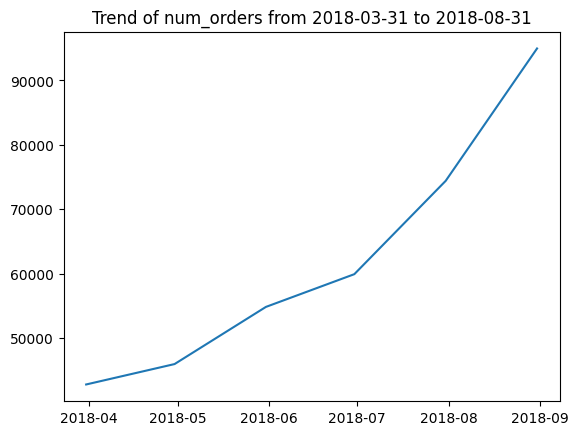

In [15]:
plt.plot(df_monthly)
plt.title('Trend of num_orders from 2018-03-31 to 2018-08-31')

Findings:

Overall number of orders are increasing throughout the time span of 5 months.

## EDA findings summary

- Overall number of orders were increasing throughout the data's time span of 5 months.
- Seasonal cycles of `num_orders` repeated daily and weekly.
    - Within a day, 06:00 and 00:00 tended to have the lowest and highest number of orders, respectively.
    - Within a week, Wednesdays and Fridays tended to have the lowest and highest number of orders, respectively.

# Machine learning

Next, we can start creating ML models. We will compare the performance of 3 regression algorithms: decision tree, random forest,  several implementations of gradient-boosting regressors, and a forecasting algorithm created by Meta: Prophet.

As mentioned in the beginning, our models must not have an RMSE score proportion higher than 48%.

## Data preprocessing

Regression models need a set of features other than the datetime index, whereas Prophet only requires the timestamps and target to make predictions.

### Feature engineering for regression models

We will use our `df_hourly` set because we need to predict the target by hour.

We will create features for the models to learn:
- `hour`
- `day`: date.
- `dayofweek`: integer ranging from `0` (Monday) to `6` (Sunday).
- `month`
- Because our set only has data of 5 months, making a `year` feature will be redundant.
- `lag`: we'll set the lag to an arbitrary value of 4 hours, which should be enough to capture recent trends.
- `moving_average`: we'll set the time window for the moving average to 24 hours to reflect the daily period of seasonality.

In [16]:
# Defining a function to create features automatically
def make_features(df, n_lag, ma_window):
    """
    Create features from a time series dataframe.
    
    Parameters:
    df: time series dataframe.
    n_lag: integer, number of preceding timestamp entries to include as features.
    ma_window: time window to calculate moving average values.
    
    Returns a dataframe with feature columns.
    """
    # Creating features from index
    df['hour'] = df.index.hour
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    df['month'] = df.index.month
    
    # Creating n_lag columns of lag features
    for lag in range(1, n_lag + 1):
        df[f'lag_{lag}'] = df['num_orders'].shift(lag)
            
    # Creating moving average feature
    # shift(1) to exclude current observation
    df['moving_average'] = df['num_orders'].shift(1).rolling(ma_window).mean()
    
    return df

In [17]:
df_regression = make_features(df_hourly, 4, 24)
df_regression.dropna(inplace=True)
df_regression

,num_orders,hour,day,dayofweek,month,lag_1,lag_2,lag_3,lag_4,moving_average
datetime,,,,,,,,,,
2018-03-02 00:00:00,90,0,2,4,3,58.0,113.0,66.0,61.0,56.833333
2018-03-02 01:00:00,120,1,2,4,3,90.0,58.0,113.0,66.0,55.416667
2018-03-02 02:00:00,75,2,2,4,3,120.0,90.0,58.0,113.0,56.875000
2018-03-02 03:00:00,64,3,2,4,3,75.0,120.0,90.0,58.0,57.041667
2018-03-02 04:00:00,20,4,2,4,3,64.0,75.0,120.0,90.0,56.958333
...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,19,31,4,8,207.0,217.0,197.0,116.0,164.875000
2018-08-31 20:00:00,154,20,31,4,8,136.0,207.0,217.0,197.0,167.541667
2018-08-31 21:00:00,159,21,31,4,8,154.0,136.0,207.0,217.0,168.041667


### Dataframe creation for Prophet

Prophet requires the timestamps to be a feature rather than the index.

In [18]:
# Creating a copy of the original df
df_prophet = df.copy()

# Resampling to aggregate hourly data
df_prophet = df_prophet.resample('1H').sum()

# Resetting the index and converting datetime to a column
df_prophet.reset_index(inplace=True)

# Renaming columns to fit Prophet's column & target naming conventions
df_prophet.rename(columns={'datetime':'ds', 'num_orders': 'y'}, inplace=True)

df_prophet

,ds,y
0,2018-03-01 00:00:00,124
1,2018-03-01 01:00:00,85
2,2018-03-01 02:00:00,71
3,2018-03-01 03:00:00,66
4,2018-03-01 04:00:00,43
...,...,...
4411,2018-08-31 19:00:00,136
4412,2018-08-31 20:00:00,154
4413,2018-08-31 21:00:00,159
4414,2018-08-31 22:00:00,223


### Training and test set splitting

We'll split the datasets into training and testing sets with a ratio of 3:1.

In [68]:
# shuffle=False to keep the data in chronological order
reg_train, reg_test = train_test_split(df_regression, train_size=0.75, shuffle=False)
pro_train, pro_test = train_test_split(df_prophet, train_size=0.75, shuffle=False)

# Resetting pro_test index to match forecast df generated by Prophet
pro_test.reset_index(drop=True, inplace=True)

# Creating a feature-only dataset for prophet forecast
pro_test_ds = pro_test.drop('y', axis=1)

# Checking set shapes and continuity
print('Regression set shapes:')
print('Training set:', reg_train.shape)
print('Training set end date:', reg_train.index.max())
print('Test set:', reg_test.shape)
print('Training set start date:', reg_test.index.min())

print()

print('Prophet set shapes:')
print('Training set:', pro_train.shape)
print('Training set end date:', pro_train.ds.max())
print('Test set:', pro_test.shape)
print('Training set start date:', pro_test.ds.min())
print('Feature-only set:', pro_test_ds.shape)

Regression set shapes:
Training set: (3294, 10)
Training set end date: 2018-07-17 05:00:00
Test set: (1098, 10)
Training set start date: 2018-07-17 06:00:00

Prophet set shapes:
Training set: (3312, 2)
Training set end date: 2018-07-16 23:00:00
Test set: (1104, 2)
Training set start date: 2018-07-17 00:00:00
Feature-only set: (1104, 1)


### Feature and target separation for regression set

Regression models need to have features and targets in separate sets. We do not need to do this with the Prophet set.

In [20]:
reg_train_feat = reg_train.drop('num_orders', axis=1)
reg_test_feat = reg_test.drop('num_orders', axis=1)

reg_train_target = reg_train['num_orders']
reg_test_target = reg_test['num_orders']

# Checking set shape
reg_train_feat.shape

(3294, 9)

## Sanity check

As a standard for our models, we can create dummy predictions without machine learning and get their RMSE scores. The two dummy predictions in question use a constant median of the whole set, while the other involves shifting the data by 1 time unit.

In [21]:
# Median dummy prediction

## Creating an array of test set's shape filled with training set's median
pred = np.ones(reg_test_target.shape) * reg_train_target.median()

## Comparing the actual test target values with the dummy prediction
## and getting the RMSE score
RMSE = mean_squared_error(reg_test_target, pred) ** 0.5
print('RMSE:', RMSE)

RMSE: 72.20693547059483


In [22]:
# Time shift dummy prediction

## Shifting the test set by 1 unit and storing it as dummy predictions
pred = reg_test_target.shift(1)

## Filling the first row with previous value from training set
pred.iloc[0] = reg_train_target.iloc[-1]

## Comparing the actual test target values with the dummy prediction
## and getting the RMSE score
RMSE = mean_squared_error(reg_test_target, pred) ** 0.5
print('RMSE:', RMSE)

RMSE: 51.91567879666058


Our models need to have RMSE lower than 51.79 in order to pass the sanity check. However, this baseline is well above Sweet Lift's requirement of RMSE 48.

## Creating scorer & score dict

We'll create an RMSE scorer for use in Bayesian optimization and a a dict to store and compare scores.

In [23]:
# Defining RMSE based on MSE function
def rmse(actual, predict):
    return mean_squared_error(actual, predict) ** 0.5 

# Creating scorer
rmse_scorer = make_scorer(rmse, greater_is_better=False)

In [24]:
# Creating (empty) score dict
score_dict = {}

## Regression

For models provided in scikit-learn, we will try and use Bayesian optimization to tune model hyperparameters automatically and cost-efficiently.

### Decision tree

In [25]:
# Hiding UserWarnings generated by skopt
warnings.filterwarnings(action='ignore', category=UserWarning)

# Creating an instance of decision tree for use by BayesSearch optimizer & cross-validator
decision_tree = BayesSearchCV(
                    estimator=DecisionTreeRegressor(random_state=random_state),
                    search_spaces={'max_depth': Integer(1, 20)},
                    random_state=random_state,
                    scoring=rmse_scorer
                )

# Executing Bayesian optimization
_ = decision_tree.fit(reg_train_feat, reg_train_target)

print('Best score:', decision_tree.best_score_)

# Reactivating UserWarnings
warnings.filterwarnings(action='default', category=UserWarning)

# Printing best model
decision_tree.best_estimator_

Best score: -25.941656507659182


DecisionTreeRegressor(max_depth=6, random_state=12345)

In [26]:
# Creating a model based on the best hyperparams
decision_tree = DecisionTreeRegressor(max_depth=6, random_state=random_state)
decision_tree.fit(reg_train_feat, reg_train_target)

DecisionTreeRegressor(max_depth=6, random_state=12345)

In [27]:
# Getting test score and storing in dict
pred = decision_tree.predict(reg_test_feat)
score = rmse(reg_test_target, pred)
score_dict['decision_tree'] = score
score

48.62175093538747

### Random forest

In [28]:
# Hiding UserWarnings generated by skopt
warnings.filterwarnings(action='ignore', category=UserWarning)

# Creating an instance of decision tree for use by BayesSearch optimizer & cross-validator
random_forest = BayesSearchCV(
                    estimator=RandomForestRegressor(random_state=random_state),
                    search_spaces={'max_depth': Integer(1, 20),
                                   'n_estimators': Integer(1, 100)},
                    random_state=random_state,
                    scoring=rmse_scorer
                )

# Executing Bayesian optimization
_ = random_forest.fit(reg_train_feat, reg_train_target)

print('Best score:', random_forest.best_score_)

# Reactivating UserWarnings
warnings.filterwarnings(action='default', category=UserWarning)

# Printing best model
random_forest.best_estimator_

Best score: -22.565283835026392


RandomForestRegressor(max_depth=20, n_estimators=97, random_state=12345)

In [29]:
# Creating a model based on the best hyperparams
random_forest = RandomForestRegressor(max_depth=20, n_estimators=97, random_state=random_state)
random_forest.fit(reg_train_feat, reg_train_target)

RandomForestRegressor(max_depth=20, n_estimators=97, random_state=12345)

In [30]:
# Getting test score and storing in dict
pred = random_forest.predict(reg_test_feat)
score = rmse(reg_test_target, pred)
score_dict['random_forest'] = score
score

42.29858950847921

### LightGBM

In [31]:
# params = {
#     'max_depth': 10,
#     'num_leaves': 100,
#     'learning_rate': 0.1,
#     'random_state': random_state
# }

# lgbm = LGBMRegressor(**params)

# lgbm.fit(X=reg_train_feat, y=reg_train_target, eval_metric=[rmse_lgbm], 
#           eval_set=[(reg_test_feat, reg_test_target)], callbacks=[early_stopping(stopping_rounds=250)])
# lgbm.get_params()

In [32]:
# # Hiding UserWarnings generated by skopt
# warnings.filterwarnings(action='ignore', category=UserWarning)

# # Creating an instance of decision tree for use by BayesSearch optimizer & cross-validator
# lgbm = BayesSearchCV(
#                     estimator=LGBMRegressor(random_state=random_state),
#                     search_spaces={'max_depth': Integer(1, 10),
#                                     'num_leaves': Integer(31, 100),
#                                     'learning_rate': Real(0.05, 0.1),},
#                     random_state=random_state,
#                     scoring=rmse_scorer
#                 )

# # Executing Bayesian optimization
# _ = lgbm.fit(reg_train_feat, reg_train_target)

# print('Best score:', lgbm.best_score_)

# # Reactivating UserWarnings
# warnings.filterwarnings(action='default', category=UserWarning)

# # Printing best model
# lgbm.best_estimator_

In [34]:
# lgbm.best_params_

In [35]:
# Creating a model based on the best hyperparams
lgbm = LGBMRegressor(max_depth=6, num_leaves=31, learning_rate=0.078, random_state=random_state)
lgbm.fit(reg_train_feat, reg_train_target)

LGBMRegressor(learning_rate=0.078, max_depth=6, random_state=12345)

In [36]:
# Getting test score and storing in dict
pred = lgbm.predict(reg_test_feat)
score = rmse(reg_test_target, pred)
score_dict['lgbm'] = score
score

43.27430368326244

### CatBoost

In [37]:
# # Hiding UserWarnings generated by skopt
# warnings.filterwarnings(action='ignore', category=UserWarning)

# # Creating an instance of decision tree for use by BayesSearch optimizer & cross-validator
# cbr = BayesSearchCV(
#                     estimator=CatBoostRegressor(grow_policy='Lossguide', od_type='Iter', od_wait=50, random_seed=random_state),
#                     search_spaces={'max_depth': Integer(1, 10),
#                                     'num_leaves': Integer(31, 100),
#                                     'iterations': Integer(10, 50)},
#                     random_state=random_state,
#                     scoring=rmse_scorer
#                 )

# # Executing Bayesian optimization
# _ = cbr.fit(reg_train_feat, reg_train_target)

# print('Best score:', cbr.best_score_)

# # Reactivating UserWarnings
# warnings.filterwarnings(action='default', category=UserWarning)

# # Printing best model
# cbr.best_estimator_

In [38]:
# cbr.best_score_

In [39]:
# cbr.best_params_

In [40]:
# Creating a model based on the best hyperparams
cbr = CatBoostRegressor(iterations=50, num_leaves=35, learning_rate=0.078, max_depth=3, 
                        grow_policy='Lossguide', random_state=random_state)
cbr.fit(reg_train_feat, reg_train_target)

0:	learn: 33.7841526	total: 153ms	remaining: 7.5s
1:	learn: 32.7857859	total: 160ms	remaining: 3.85s
2:	learn: 31.9283180	total: 165ms	remaining: 2.58s
3:	learn: 31.1697273	total: 168ms	remaining: 1.93s
4:	learn: 30.3885534	total: 171ms	remaining: 1.54s
5:	learn: 29.8621993	total: 174ms	remaining: 1.27s
6:	learn: 29.2653679	total: 177ms	remaining: 1.08s
7:	learn: 28.8428442	total: 179ms	remaining: 939ms
8:	learn: 28.3914732	total: 181ms	remaining: 825ms
9:	learn: 27.8945998	total: 183ms	remaining: 731ms
10:	learn: 27.5531385	total: 184ms	remaining: 654ms
11:	learn: 27.1905429	total: 186ms	remaining: 589ms
12:	learn: 26.7711585	total: 188ms	remaining: 534ms
13:	learn: 26.3416604	total: 189ms	remaining: 486ms
14:	learn: 26.0390800	total: 191ms	remaining: 445ms
15:	learn: 25.8103991	total: 192ms	remaining: 408ms
16:	learn: 25.6499597	total: 193ms	remaining: 375ms
17:	learn: 25.4708062	total: 195ms	remaining: 346ms
18:	learn: 25.2699134	total: 196ms	remaining: 320ms
19:	learn: 25.0848828	t

In [41]:
# Getting test score and storing in dict
pred = cbr.predict(reg_test_feat)
score = rmse(reg_test_target, pred)
score_dict['cbr'] = score
score

49.523793237154905

## Prophet

Training and getting predictions from Prophet is different from previously used regression models. We need to fit the model to the dataframe we created for Prophet. Calling the `predict` method on Prophet will return a dataframe. We can get the `yhat` column from said dataframe and compare it with our actual target (`y`) to get the RMSE score.

Prophet also has a built-in plotting function.

In [69]:
prophet = Prophet()
prophet.fit(pro_train)

forecast = prophet.predict(pro_test_ds)

score = rmse(forecast['yhat'], pro_test['y'])
score_dict['prophet'] = score
score

20:31:31 - cmdstanpy - INFO - Chain [1] start processing
20:31:31 - cmdstanpy - INFO - Chain [1] done processing


42.01854743458565

In [74]:
# Appending actual y values to forecast df
forecast['y'] = pro_test['y']
plot_plotly(prophet, forecast)

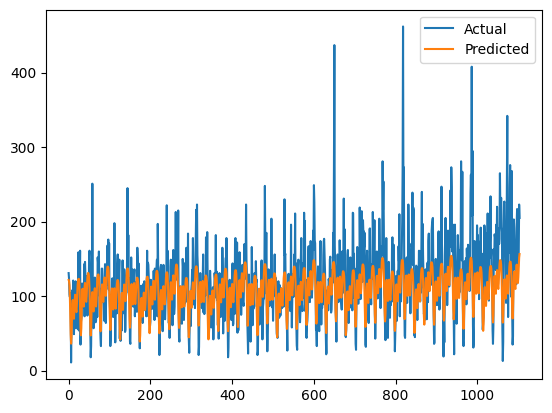

In [77]:
plt.plot(forecast['y'], label='Actual')
plt.plot(forecast['yhat'], label='Predicted')
plt.legend()
plt.show()

In [44]:
plot_components_plotly(prophet, forecast)

## ML summary

In this part, we created two types of models: regressors, whose hyperparameters we optimized with Bayesian optimization, and Prophet.

Models returned the following RMSE scores after predicting the test set:

In [45]:
score_df = pd.DataFrame.from_dict(data=score_dict, orient='index', columns=['score'])
score_df

,score
decision_tree,48.621751
random_forest,42.298590
lgbm,43.274304
cbr,49.523793
prophet,42.018547


Findings:
- **Prophet** was the best model with an RMSE of **~42**.
- Regressors had worse scores. Random forest regressor and LightGBM regressor passed the baseline RMSE requirement, while decision tree and CatBoost regressors did not.
- All models passed the sanity check.

# Conclusion

We were given a set of amount of orders in 26,496 timestamps. The timestamps were in  chronological order with increments of 10 minute, ranging from 1 March 2018 at 00:00:00 to 31 August 2018 at 23:50:00. The set had no missing or impossible values.

In EDA, we resampled the data by hour, day, and month to uncover trends and seasonality. 
- Overall number of orders were increasing throughout the 5-month span. 
- It had two visible seasonal cycles:
	- daily cycles, with low points occuring every 06:00 and high points at 00:00
	- weekly cycles, with low points at Wednesdays and high points at Fridays.

Next, we processed the data for processing by ML models.
- As the base, we used the hourly set from EDA. The set had 4416 rows of data.
- Feature engineering: we created several features for regression models to learn:
	- `hour`
	- `day`
	- `dayofweek`
	- `month`
	- `lag` of `4`,
	- `moving_average` with a time window of `24` hours.
- Due to difference in algorithms, we created a different set for Prophet.
- Splitting: sets were divided into training and test sets with a ratio of 3:1.

As a measure of sanity check, we created two dummy predictions. The check resulted in a baseline score of RMSE ~51.9, higher than our requested maximum of 48.

We created, trained, and tested two types of models:
- regressors (decision tree, random forest, LightGBM, and CatBoost) which were tuned with Bayesian optimization algorithm provided by skopt,
- time series forecasting model: Prophet from Meta.

Only random forest and LightGBM regressors, and Prophet passed the sanity check. 

The best model for this task would be **Prophet (RMSE ~42), trained with our dataset.**